# Speech Emotion Recognition

### Import necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import IPython
import librosa # librosa is a Python library for analyzing audio and music used to extract the data from audio files it later
import librosa.display
from IPython.display import Audio # to play the audio files
plt.style.use('seaborn-white')
from python_speech_features import mfcc

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from os.path import dirname, join as pjoin
from scipy.io import wavfile
import scipy.io

from keras.layers.normalization import layer_normalization
from tensorflow.keras.models import Sequential
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

C:\Users\TestUser\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### Data Collection

Path of the TESS dataset.

In [2]:
Tess = 'C:/Users/TestUser/OneDrive/Documents/Data Science Capstone/Dataset/TESS Toronto emotional speech set data'

Create a list of the different emotion folders from the dataset.

In [3]:
path = []

emotion = []

directory = os.listdir(Tess)

directory

['OAF_angry',
 'OAF_disgust',
 'OAF_Fear',
 'OAF_happy',
 'OAF_neutral',
 'OAF_Pleasant_surprise',
 'OAF_Sad',
 'YAF_angry',
 'YAF_disgust',
 'YAF_fear',
 'YAF_happy',
 'YAF_neutral',
 'YAF_pleasant_surprised',
 'YAF_sad']

For loop to go through each folder, then through each file in the folders. Then assign the proper emotion to each of the files.

In [4]:
for i in directory:
    
    folder = os.listdir(Tess + '/' + i)      
    
    for k in folder:
        
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotion.append('Angry')
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotion.append('Disgust')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotion.append('Fear')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion.append('Happy')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion.append('Neutral')                                
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            emotion.append('Surprise')               
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion.append('Sad')
        else:
            emotion.append('Unknown')
        path.append(Tess + "/" + i + "/" + k)

Create a dataframe of with each file path and its corresponding emotion.

In [5]:
Tess_df = pd.DataFrame(emotion, columns = ['Emotions'])

Tess_df = pd.concat([Tess_df, pd.DataFrame(path, columns = ['Path'])], axis = 1)

Tess_df.head()

,Emotions,Path
0,Angry,C:/Users/TestUser/OneDrive/Documents/Data Scie...
1,Angry,C:/Users/TestUser/OneDrive/Documents/Data Scie...
2,Angry,C:/Users/TestUser/OneDrive/Documents/Data Scie...
3,Angry,C:/Users/TestUser/OneDrive/Documents/Data Scie...
4,Angry,C:/Users/TestUser/OneDrive/Documents/Data Scie...


### Data Preprocessing

Look at how many of each emotion there are. There should be 400 files for each emotion. (200 per female).

In [6]:
Tess_df['Emotions'].value_counts()

Angry       400
Disgust     400
Fear        400
Happy       400
Neutral     400
Surprise    400
Sad         400
Name: Emotions, dtype: int64

Check data types.

In [7]:
Tess_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Emotions  2800 non-null   object
 1   Path      2800 non-null   object
dtypes: object(2)
memory usage: 43.9+ KB


In [8]:
Tess_df.describe()

,Emotions,Path
count,2800,2800
unique,7,2800
top,Angry,C:/Users/TestUser/OneDrive/Documents/Data Scie...
freq,400,1


In [9]:
Tess_df.shape

(2800, 2)

### Exploratory Data Analysis

Plot the counts of each emotion. 

<AxesSubplot:xlabel='Emotions', ylabel='count'>

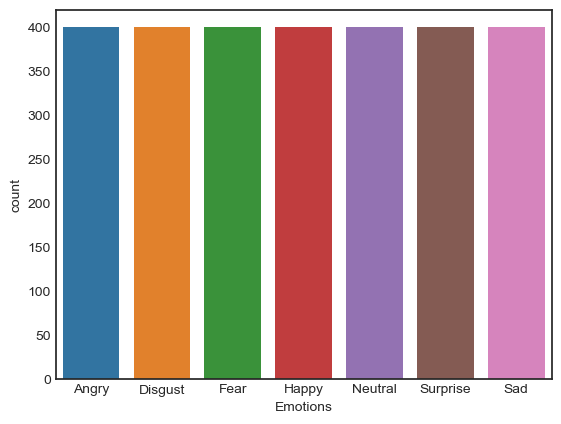

In [10]:
sns.countplot(data = Tess_df, x = 'Emotions')

Create a waveplot. Waveplots show how loud the audio is at different times.

Show the audio file.

In [11]:
def waveplot(array, sampling_rate, emotion):
    
    plt.figure(figsize = (8, 3))
    
    plt.title("Digital Representation of " + emotion, size = 15)
    
    # Visualize a waveform in the time domain. This function constructs a plot which adaptively switches between a raw
    # samples-based view of the signal and an amplitude-envelope view of the signal depending on the time extent of 
    # the plot's viewport.
    librosa.display.waveshow(array, sr = sampling_rate)
    
    plt.show()

Create a spectrogram. A spectrogram is a graphic of the frequency spectrum of sound or other signals as it varies over time.

In [12]:
def spectrogram(array, sampling_rate, emotion):
    
    # Short-time Fourier transform (STFT). The STFT represents a signal in the time-frequency domain by 
    # computing discrete Fourier transforms (DFT) over short overlapping windows.
    x = librosa.stft(array)
    
    # Convert an amplitude spectrogram to dB-scaled spectrogram.
    x_db_scale = librosa.amplitude_to_db(abs(x))
    
    plt.figure(figsize = (8, 3))
    
    plt.title("Spectrogram of " + emotion, size = 15)
    
    librosa.display.specshow(x_db_scale, sr = sampling_rate, x_axis = 'time', y_axis = 'hz')

#### Example: Angry

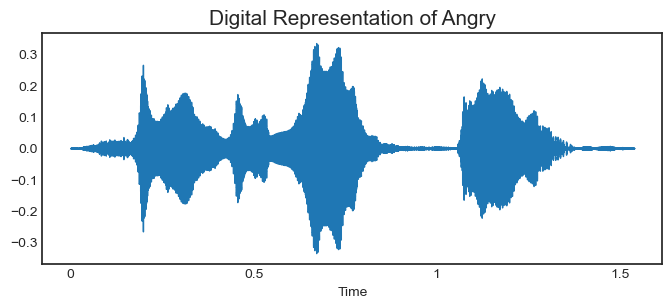

In [13]:
emotion = 'Angry'

# Select the first file in the 'Angry' emotion folder.
path = np.array(Tess_df['Path'][Tess_df['Emotions'] == emotion])[0]

# Load an audio file as a floating point time series. Could also use wavfile.read(path)
array, sampling_rate = librosa.load(path)

# Use waveplot function
waveplot(array, sampling_rate, emotion)

# Create an audio object. When this object is returned by an input cell or passed to the display function, it will 
# result in Audio controls being displayed in the frontend.
Audio(data = path)

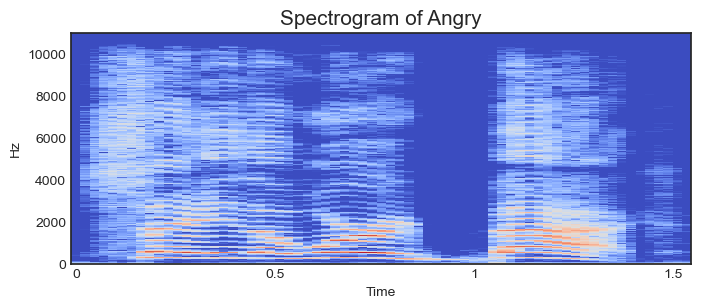

In [14]:
emotion = 'Angry'

# Select the first file in the 'Angry' emotion folder.
path = np.array(Tess_df['Path'][Tess_df['Emotions'] == emotion])[0]

# Load an audio file as a floating point time series. Could also use wavfile.read(path)
array, sampling_rate = librosa.load(path)

# Use spectrogram function
spectrogram(array, sampling_rate, emotion)

Create a Mel Spectrogram and a Mel-frequency cepstral coefficients (MFCCs) graph

In [15]:
S = librosa.feature.melspectrogram(y = array, sr = sampling_rate, n_mels = 128, fmax = 8000)

librosa.feature.mfcc(S = librosa.power_to_db(S))

array([[-5.9806213e+02, -5.4520355e+02, -4.6374698e+02, ...,
        -5.0596753e+02, -5.5042389e+02, -5.8807922e+02],
       [ 1.2092262e+01, -3.2368855e+01, -5.3632412e+01, ...,
         2.9912830e+01,  2.9154491e+01,  1.7776749e+01],
       [ 1.1864337e+01,  3.9071381e+01,  4.0050079e+01, ...,
        -1.9263218e+01, -9.2050803e-01,  8.1454573e+00],
       ...,
       [ 7.5929470e+00,  8.7036934e+00,  8.4721441e+00, ...,
        -4.8368630e+00, -9.8117989e-01,  2.2103944e+00],
       [ 7.0219545e+00,  8.0315857e+00,  1.1227475e+01, ...,
        -3.3556730e-01,  1.3691396e+00,  3.7088799e+00],
       [ 6.3970308e+00,  6.2985744e+00,  1.1988241e+01, ...,
         5.2608118e+00,  7.2037363e+00,  8.7089376e+00]], dtype=float32)

In [16]:
# Get more components
mfccs = librosa.feature.mfcc(y = array, sr = sampling_rate, n_mfcc = 40)

"In the spectrogram view, the vertical axis displays frequency in Hertz, the horizontal axis represents time (just like the waveform display), and amplitude is represented by brightness. The black background is silence, while the bright orange curve is the sine wave moving up in pitch. This allows us to view a range of frequencies (lowest at the bottom of the display, highest at the top) and how loud events at different frequencies are. Loud events will appear bright and quiet events will appear dark."

[Text(0.5, 1.0, 'MFCC - Angry')]

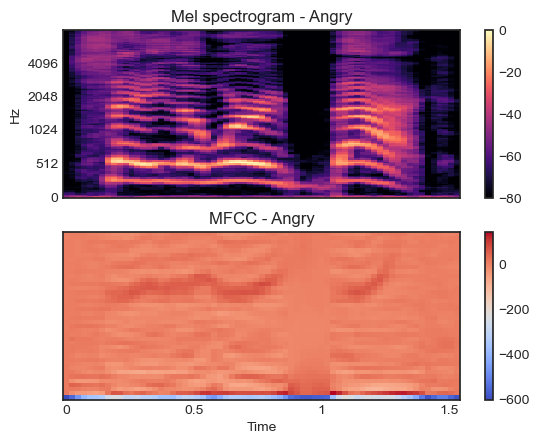

In [17]:
# Visualize the MFCC series
fig, ax = plt.subplots(nrows = 2, sharex = True)

img = librosa.display.specshow(librosa.power_to_db(S, ref = np.max), x_axis = 'time', y_axis = 'mel', fmax = 8000, ax = ax[0])

fig.colorbar(img, ax = [ax[0]])

ax[0].set(title = 'Mel spectrogram - Angry')

ax[0].label_outer()

img = librosa.display.specshow(mfccs, x_axis = 'time', ax = ax[1])

fig.colorbar(img, ax = [ax[1]])

ax[1].set(title = 'MFCC - Angry')

#### Example: Disgust

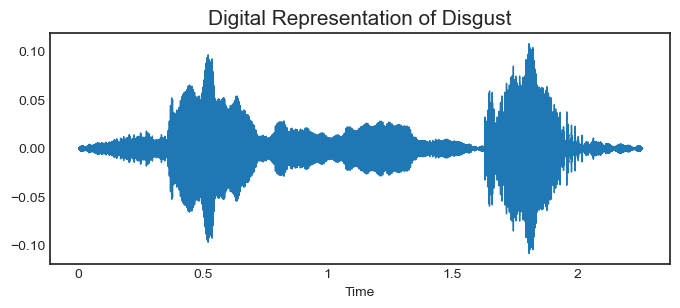

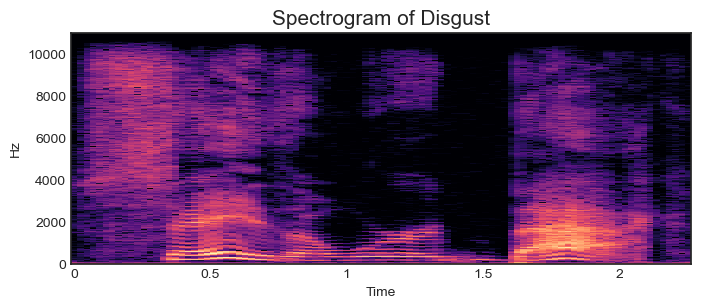

In [18]:
emotion = 'Disgust'

path = np.array(Tess_df['Path'][Tess_df['Emotions'] == emotion])[0]

array, sampling_rate = librosa.load(path)

waveplot(array, sampling_rate, emotion)

spectrogram(array, sampling_rate, emotion)

Audio(data = path)

[Text(0.5, 1.0, 'MFCC - Disgust')]

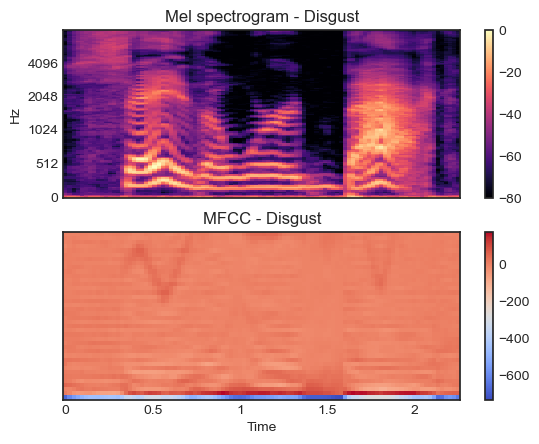

In [19]:
S = librosa.feature.melspectrogram(y = array, sr = sampling_rate, n_mels = 128, fmax = 8000)

mfccs = librosa.feature.mfcc(y = array, sr = sampling_rate, n_mfcc = 40)

fig, ax = plt.subplots(nrows = 2, sharex = True)

img = librosa.display.specshow(librosa.power_to_db(S, ref = np.max), x_axis = 'time', y_axis = 'mel', fmax = 8000, ax = ax[0])

fig.colorbar(img, ax = [ax[0]])

ax[0].set(title = 'Mel spectrogram - Disgust')

ax[0].label_outer()

img = librosa.display.specshow(mfccs, x_axis = 'time', ax = ax[1])

fig.colorbar(img, ax = [ax[1]])

ax[1].set(title = 'MFCC - Disgust')

#### Example: Fear

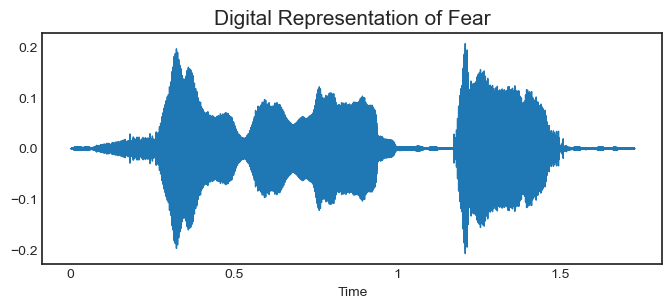

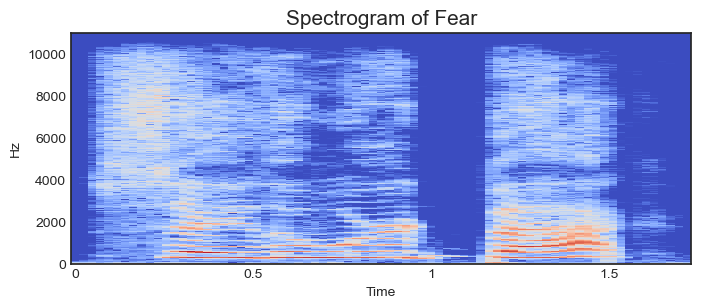

In [20]:
emotion = 'Fear'

path = np.array(Tess_df['Path'][Tess_df['Emotions'] == emotion])[0]

array, sampling_rate = librosa.load(path)

waveplot(array, sampling_rate, emotion)

spectrogram(array, sampling_rate, emotion)

Audio(data = path)

[Text(0.5, 1.0, 'MFCC - Fear')]

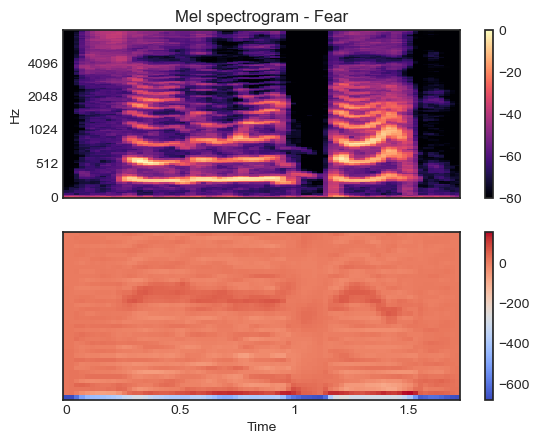

In [21]:
S = librosa.feature.melspectrogram(y = array, sr = sampling_rate, n_mels = 128, fmax = 8000)

mfccs = librosa.feature.mfcc(y = array, sr = sampling_rate, n_mfcc = 40)

fig, ax = plt.subplots(nrows = 2, sharex = True)

img = librosa.display.specshow(librosa.power_to_db(S, ref = np.max), x_axis = 'time', y_axis = 'mel', fmax = 8000, ax = ax[0])

fig.colorbar(img, ax = [ax[0]])

ax[0].set(title = 'Mel spectrogram - Fear')

ax[0].label_outer()

img = librosa.display.specshow(mfccs, x_axis = 'time', ax = ax[1])

fig.colorbar(img, ax = [ax[1]])

ax[1].set(title = 'MFCC - Fear')

#### Example: Happy

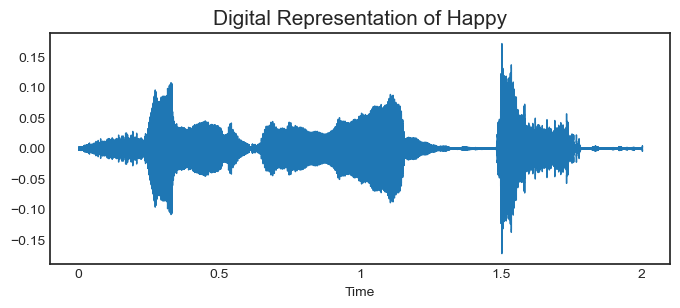

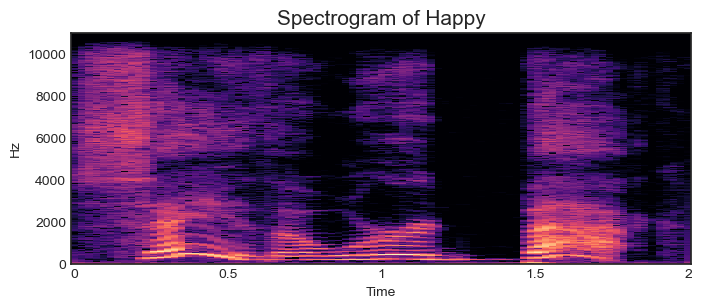

In [22]:
emotion = 'Happy'

path = np.array(Tess_df['Path'][Tess_df['Emotions'] == emotion])[0]

array, sampling_rate = librosa.load(path)

waveplot(array, sampling_rate, emotion)

spectrogram(array, sampling_rate, emotion)

Audio(data = path)

[Text(0.5, 1.0, 'MFCC - Happy')]

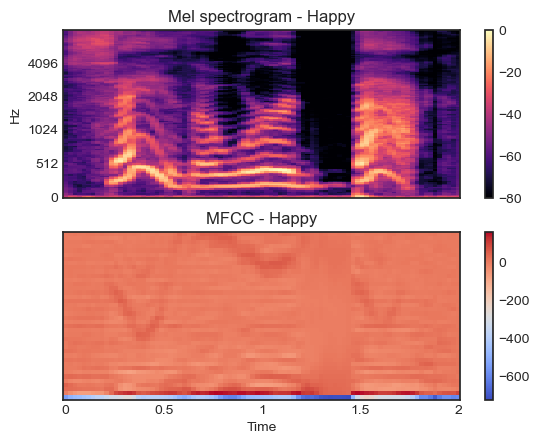

In [23]:
S = librosa.feature.melspectrogram(y = array, sr = sampling_rate, n_mels = 128, fmax = 8000)

mfccs = librosa.feature.mfcc(y = array, sr = sampling_rate, n_mfcc = 40)

fig, ax = plt.subplots(nrows = 2, sharex = True)

img = librosa.display.specshow(librosa.power_to_db(S, ref = np.max), x_axis = 'time', y_axis = 'mel', fmax = 8000, ax = ax[0])

fig.colorbar(img, ax = [ax[0]])

ax[0].set(title = 'Mel spectrogram - Happy')

ax[0].label_outer()

img = librosa.display.specshow(mfccs, x_axis = 'time', ax = ax[1])

fig.colorbar(img, ax = [ax[1]])

ax[1].set(title = 'MFCC - Happy')

#### Example: Neutral

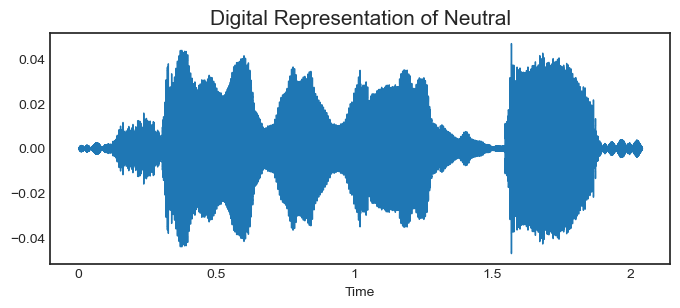

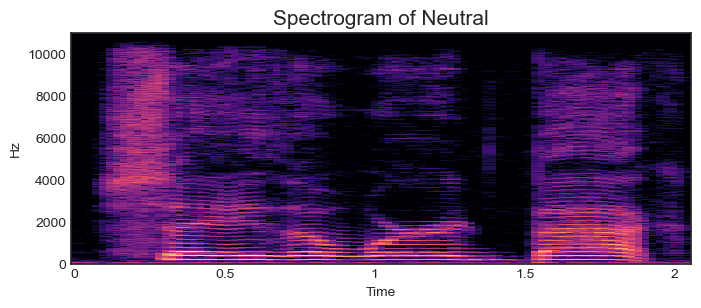

In [24]:
emotion = 'Neutral'

path = np.array(Tess_df['Path'][Tess_df['Emotions'] == emotion])[0]

array, sampling_rate = librosa.load(path)

waveplot(array, sampling_rate, emotion)

spectrogram(array, sampling_rate, emotion)

Audio(data = path)

[Text(0.5, 1.0, 'MFCC - Neutral')]

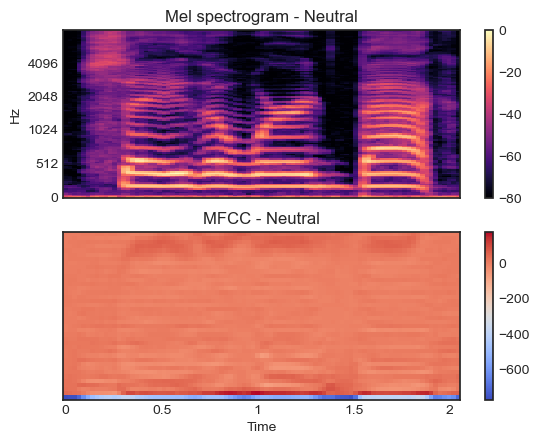

In [25]:
S = librosa.feature.melspectrogram(y = array, sr = sampling_rate, n_mels = 128, fmax = 8000)

mfccs = librosa.feature.mfcc(y = array, sr = sampling_rate, n_mfcc = 40)

fig, ax = plt.subplots(nrows = 2, sharex = True)

img = librosa.display.specshow(librosa.power_to_db(S, ref = np.max), x_axis = 'time', y_axis = 'mel', fmax = 8000, ax = ax[0])

fig.colorbar(img, ax = [ax[0]])

ax[0].set(title = 'Mel spectrogram - Neutral')

ax[0].label_outer()

img = librosa.display.specshow(mfccs, x_axis = 'time', ax = ax[1])

fig.colorbar(img, ax = [ax[1]])

ax[1].set(title = 'MFCC - Neutral')

#### Example: Surprise

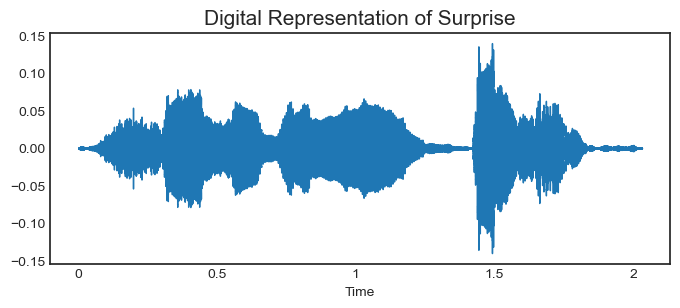

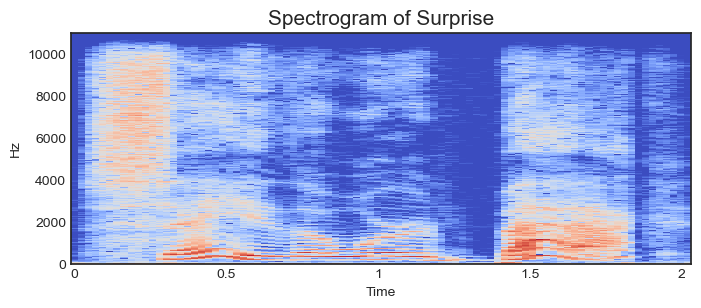

In [26]:
emotion = 'Surprise'

path = np.array(Tess_df['Path'][Tess_df['Emotions'] == emotion])[0]

array, sampling_rate = librosa.load(path)

waveplot(array, sampling_rate, emotion)

spectrogram(array, sampling_rate, emotion)

Audio(data = path)

[Text(0.5, 1.0, 'MFCC - Surprise')]

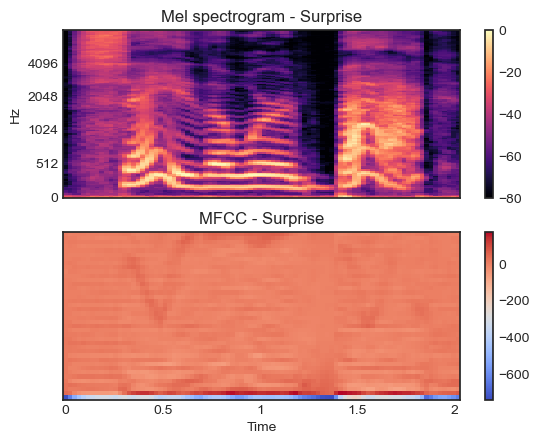

In [27]:
S = librosa.feature.melspectrogram(y = array, sr = sampling_rate, n_mels = 128, fmax = 8000)

mfccs = librosa.feature.mfcc(y = array, sr = sampling_rate, n_mfcc = 40)

fig, ax = plt.subplots(nrows = 2, sharex = True)

img = librosa.display.specshow(librosa.power_to_db(S, ref = np.max), x_axis = 'time', y_axis = 'mel', fmax = 8000, ax = ax[0])

fig.colorbar(img, ax = [ax[0]])

ax[0].set(title = 'Mel spectrogram - Surprise')

ax[0].label_outer()

img = librosa.display.specshow(mfccs, x_axis = 'time', ax = ax[1])

fig.colorbar(img, ax = [ax[1]])

ax[1].set(title = 'MFCC - Surprise')

#### Example: Sad

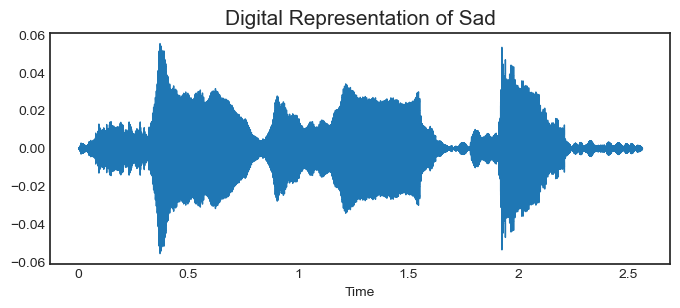

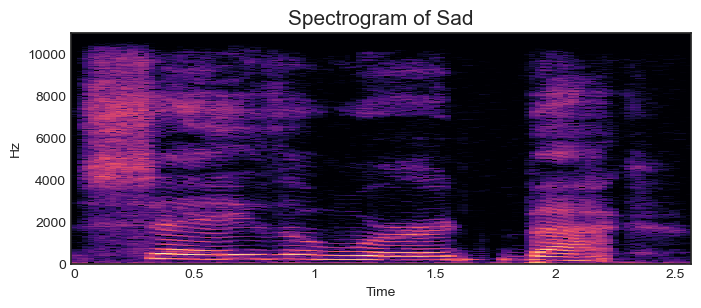

In [28]:
emotion = 'Sad'

path = np.array(Tess_df['Path'][Tess_df['Emotions'] == emotion])[0]

array, sampling_rate = librosa.load(path)

waveplot(array, sampling_rate, emotion)

spectrogram(array, sampling_rate, emotion)

Audio(data = path)

[Text(0.5, 1.0, 'MFCC - Sad')]

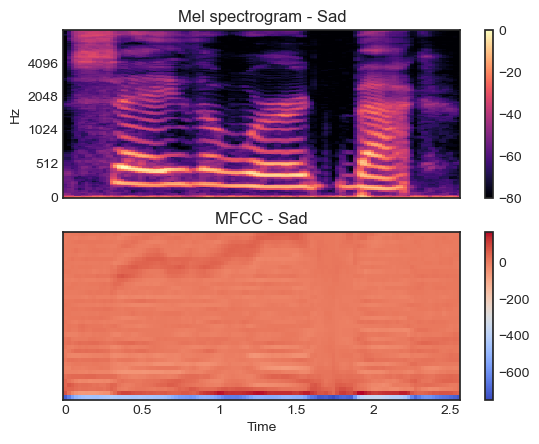

In [29]:
S = librosa.feature.melspectrogram(y = array, sr = sampling_rate, n_mels = 128, fmax = 8000)

mfccs = librosa.feature.mfcc(y = array, sr = sampling_rate, n_mfcc = 40)

fig, ax = plt.subplots(nrows = 2, sharex = True)

img = librosa.display.specshow(librosa.power_to_db(S, ref = np.max), x_axis = 'time', y_axis = 'mel', fmax = 8000, ax = ax[0])

fig.colorbar(img, ax = [ax[0]])

ax[0].set(title = 'Mel spectrogram - Sad')

ax[0].label_outer()

img = librosa.display.specshow(mfccs, x_axis = 'time', ax = ax[1])

fig.colorbar(img, ax = [ax[1]])

ax[1].set(title = 'MFCC - Sad')

Compare all of the Mel Spectrograms

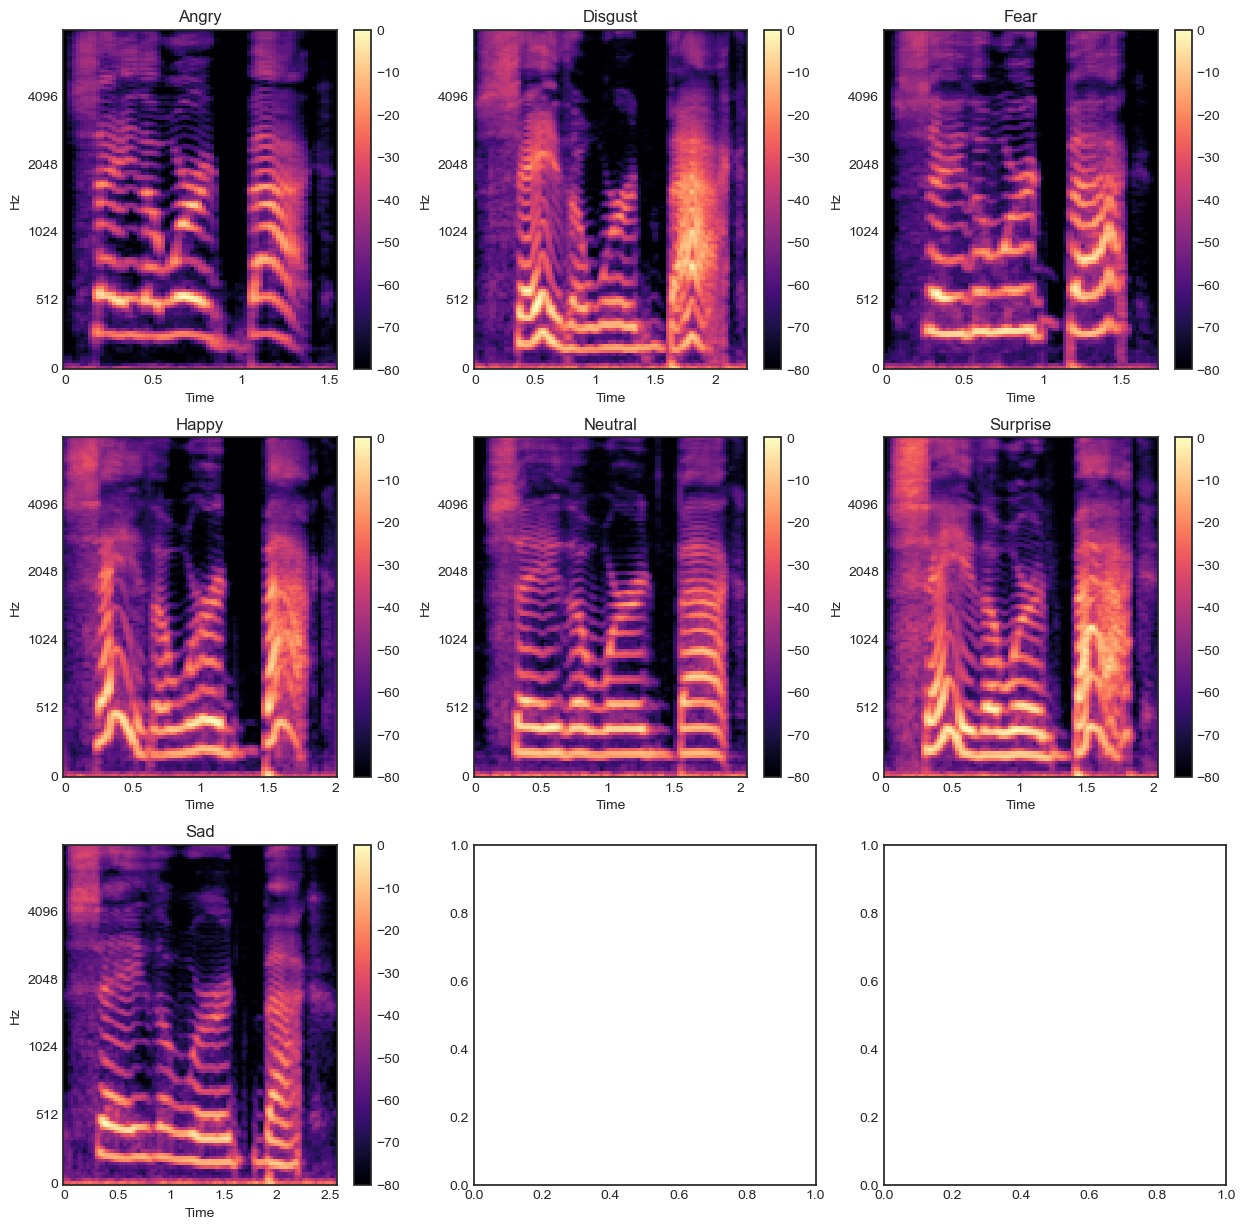

In [30]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (15, 15))

# Plot for Angry
emotion = 'Angry'
path = np.array(Tess_df['Path'][Tess_df['Emotions'] == emotion])[0]
array, sampling_rate = librosa.load(path)
S = librosa.feature.melspectrogram(y = array, sr = sampling_rate, n_mels = 128, fmax = 8000)
mfccs = librosa.feature.mfcc(y = array, sr = sampling_rate, n_mfcc = 40)
img = librosa.display.specshow(librosa.power_to_db(S, ref = np.max), x_axis = 'time', y_axis = 'mel', fmax = 8000, ax = axes[0, 0])
fig.colorbar(img, ax = [axes[0, 0]])
axes[0, 0].set_title('Angry')
ax[0].label_outer()

# Plot for Disgust
emotion = 'Disgust'
path = np.array(Tess_df['Path'][Tess_df['Emotions'] == emotion])[0]
array, sampling_rate = librosa.load(path)
S = librosa.feature.melspectrogram(y = array, sr = sampling_rate, n_mels = 128, fmax = 8000)
mfccs = librosa.feature.mfcc(y = array, sr = sampling_rate, n_mfcc = 40)
img = librosa.display.specshow(librosa.power_to_db(S, ref = np.max), x_axis = 'time', y_axis = 'mel', fmax = 8000, ax = axes[0, 1])
fig.colorbar(img, ax = [axes[0, 1]])
axes[0, 1].set_title('Disgust')
ax[0].label_outer()

# Plot for Fear
emotion = 'Fear'
path = np.array(Tess_df['Path'][Tess_df['Emotions'] == emotion])[0]
array, sampling_rate = librosa.load(path)
S = librosa.feature.melspectrogram(y = array, sr = sampling_rate, n_mels = 128, fmax = 8000)
mfccs = librosa.feature.mfcc(y = array, sr = sampling_rate, n_mfcc = 40)
img = librosa.display.specshow(librosa.power_to_db(S, ref = np.max), x_axis = 'time', y_axis = 'mel', fmax = 8000, ax = axes[0, 2])
fig.colorbar(img, ax = [axes[0, 2]])
axes[0, 2].set_title('Fear')
ax[0].label_outer()

# Plot for Happy
emotion = 'Happy'
path = np.array(Tess_df['Path'][Tess_df['Emotions'] == emotion])[0]
array, sampling_rate = librosa.load(path)
S = librosa.feature.melspectrogram(y = array, sr = sampling_rate, n_mels = 128, fmax = 8000)
mfccs = librosa.feature.mfcc(y = array, sr = sampling_rate, n_mfcc = 40)
img = librosa.display.specshow(librosa.power_to_db(S, ref = np.max), x_axis = 'time', y_axis = 'mel', fmax = 8000, ax = axes[1, 0])
fig.colorbar(img, ax = [axes[1, 0]])
axes[1, 0].set_title('Happy')
ax[0].label_outer()

# Plot for Neutral
emotion = 'Neutral'
path = np.array(Tess_df['Path'][Tess_df['Emotions'] == emotion])[0]
array, sampling_rate = librosa.load(path)
S = librosa.feature.melspectrogram(y = array, sr = sampling_rate, n_mels = 128, fmax = 8000)
mfccs = librosa.feature.mfcc(y = array, sr = sampling_rate, n_mfcc = 40)
img = librosa.display.specshow(librosa.power_to_db(S, ref = np.max), x_axis = 'time', y_axis = 'mel', fmax = 8000, ax = axes[1, 1])
fig.colorbar(img, ax = [axes[1, 1]])
axes[1, 1].set_title('Neutral')
ax[0].label_outer()

# Plot for Surprise
emotion = 'Surprise'
path = np.array(Tess_df['Path'][Tess_df['Emotions'] == emotion])[0]
array, sampling_rate = librosa.load(path)
S = librosa.feature.melspectrogram(y = array, sr = sampling_rate, n_mels = 128, fmax = 8000)
mfccs = librosa.feature.mfcc(y = array, sr = sampling_rate, n_mfcc = 40)
img = librosa.display.specshow(librosa.power_to_db(S, ref = np.max), x_axis = 'time', y_axis = 'mel', fmax = 8000, ax = axes[1, 2])
fig.colorbar(img, ax = [axes[1, 2]])
axes[1, 2].set_title('Surprise')
ax[0].label_outer()

# Plot for Sad
emotion = 'Sad'
path = np.array(Tess_df['Path'][Tess_df['Emotions'] == emotion])[0]
array, sampling_rate = librosa.load(path)
S = librosa.feature.melspectrogram(y = array, sr = sampling_rate, n_mels = 128, fmax = 8000)
mfccs = librosa.feature.mfcc(y = array, sr = sampling_rate, n_mfcc = 40)
img = librosa.display.specshow(librosa.power_to_db(S, ref = np.max), x_axis = 'time', y_axis = 'mel', fmax = 8000, ax = axes[2, 0])
fig.colorbar(img, ax = [axes[2, 0]])
axes[2, 0].set_title('Sad')
ax[0].label_outer()

### Data Augmentation

By adding minor changes to my training set, I can generate new data samples with a technique known as data augmentation. I  can use techniques such as noise injection, time shifting, pitch and speed changes, etc. to produce data for the audio. Making my models resistant to these disturbances will increase their transferability into real-world situations. The label from the training set must be preserved when adding the disturbances for this to work. First I need to determine which augmentation strategies fit my dataset the best.

In [31]:
def noise(array):
    
    noise_aug = np.random.uniform() * np.amax(array) * 0.06 
    
    array = (noise_aug * np.random.normal(size = array.shape[0])) + array 
    
    return array


def pitch(array, sampling_rate):
    
    return librosa.effects.pitch_shift(y = array, sr = sampling_rate, n_steps = 1.1)


def slow(array, sampling_rate = 0.4):
    
    return librosa.effects.time_stretch(y = array, rate = sampling_rate)


def fast(array, sampling_rate = 1.5):
    
    return librosa.effects.time_stretch(y = array, rate = sampling_rate)


def shift(array):
    
    shift_aug = int(np.random.uniform(low = -20, high = 10) * 1000)
    
    return np.roll(a = array, shift = shift_aug)

In [32]:
path = np.array(Tess_df['Path'])[1]

array, sampling_rate = librosa.load(path = path)

#### 1. Normal Audio

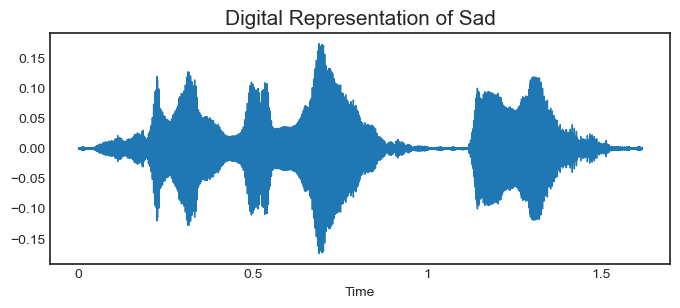

In [33]:
waveplot(array, sampling_rate, emotion)

Audio(path)

#### 2. Noise

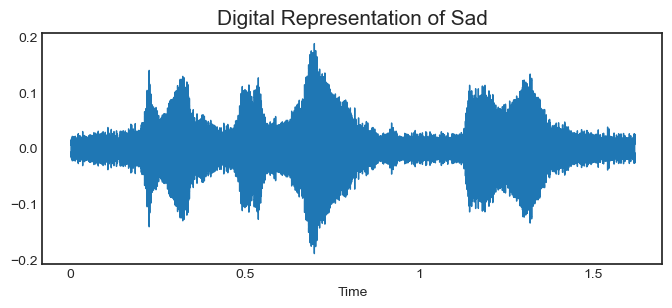

In [34]:
aug = noise(array)

waveplot(aug, sampling_rate, emotion)

Audio(aug, rate = sampling_rate)

#### 3. Pitch

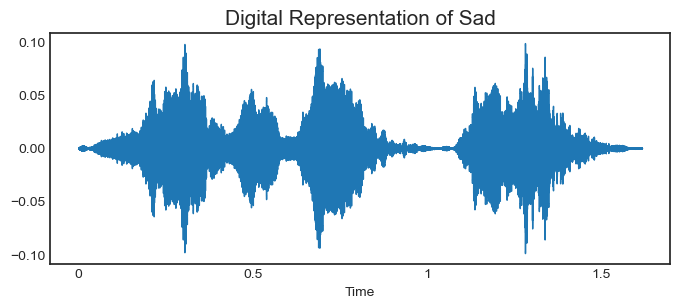

In [35]:
aug = pitch(array, sampling_rate)

waveplot(aug, sampling_rate, emotion)

Audio(aug, rate = sampling_rate)

#### 4. Slow Down

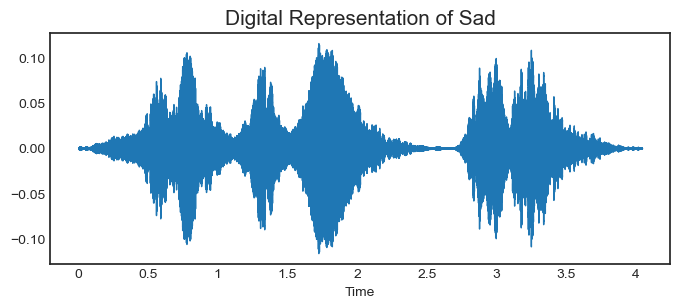

In [36]:
aug = slow(array)

waveplot(aug, sampling_rate, emotion)

Audio(aug, rate = sampling_rate)

#### 4. Speed Up

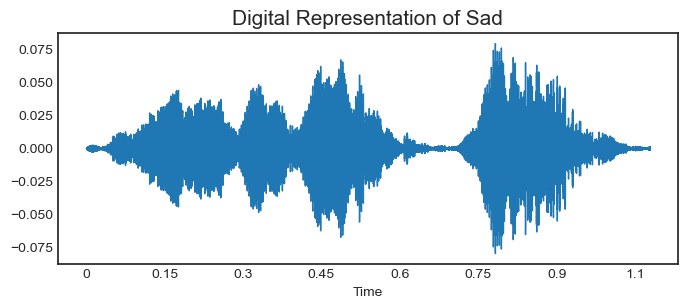

In [37]:
aug = fast(array)

waveplot(aug, sampling_rate, emotion)

Audio(aug, rate = sampling_rate)

#### 6. Shift

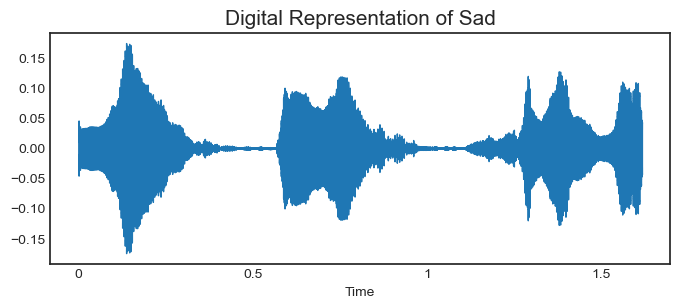

In [38]:
aug = shift(array)

waveplot(aug, sampling_rate, emotion)

Audio(aug, rate = sampling_rate)

### Feature Extraction

Since the models cannot simply interpret the information supplied by the audio files, I must turn it into a structure that can be comprehended by them via feature extraction. The three axes of the audio signal—time, amplitude, and frequency—represent its three dimensions.

A crucial step in studying and discovering relationships between various variables is feature extraction. I need to transform the audio data presented into a type that the models can interpret. I  can conduct a number of manipulations on the data and sampling rate to derive useful information from them.

In [39]:
def extract_feats(array):
    
    # MFCC
    result = np.array([])
    mfcc = librosa.feature.mfcc(y = array, sr = sampling_rate)
    mfcc_mean = np.mean(mfcc.T, axis = 0)
    result = np.hstack((result, mfcc_mean))  # Horizontal Stack
    
    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y = array)
    zcr_mean = np.mean(zcr.T, axis = 0)
    result = np.hstack((result, zcr_mean))  # Horizontal Stack
    
    # Mel Spectogram
    melspec = librosa.feature.melspectrogram(y = array, sr = sampling_rate)
    melspec_mean = np.mean(melspec.T, axis = 0)
    result = np.hstack((result, melspec_mean))  # Horizontal Stack

    # Root Mean Square Value
    rmsv = librosa.feature.rms(y = array)
    rmsv_mean = np.mean(rmsv.T, axis = 0)
    result = np.hstack((result, rmsv_mean))  # Horizontal Stack
    
    # Chroma
    stft = np.abs(librosa.stft(array))
    chroma_stft = librosa.feature.chroma_stft(S = stft, sr = sampling_rate)
    chroma_stft_mean = np.mean(chroma_stft.T, axis = 0)
    result = np.hstack((result, chroma_stft_mean))  # Horizontal Stack  
    
    # Spectral Centroid
    spectral = librosa.feature.spectral_centroid(y = array)
    spectral_mean = np.mean(spectral.T, axis = 0)
    result = np.hstack((result, spectral_mean))  # Horizontal Stack
     
    return result

In [40]:
def get_feats(path):
    
    # Duration and offset takes care of the noise, pitch, slow down, etc.
    array, sampling_rate = librosa.load(path, duration = 3, offset = 0.6)
    
    # Normal Audio
    resample_norm = extract_feats(array)
    result = np.array(resample_norm)
    
    # Noise
    get_noise = noise(array)
    resample_noise = extract_feats(get_noise)
    result = np.vstack((result, resample_noise))  # Vertical Stack
    
    # Pitch
    get_pitch = pitch(array, sampling_rate)
    resample_pitch = extract_feats(get_pitch)
    result = np.vstack((result, resample_pitch))  # Vertical Stack
    
    # Slow Down
    get_slow = slow(array)
    resample_slow = extract_feats(get_slow)
    result = np.vstack((result, resample_slow))  # Vertical Stack
    
    # Speed Up
    get_fast = fast(array)
    resample_fast = extract_feats(get_fast)
    result = np.vstack((result, resample_fast))  # Vertical Stack
    
    # Shift
    get_shift = shift(array)
    resample_shift = extract_feats(get_shift)
    result = np.vstack((result, resample_shift))  # Vertical Stack
    
    return result

In [41]:
X, y = [], []

for path, emotion in zip(Tess_df['Path'], Tess_df['Emotions']):
    
    feat = get_feats(path)
    
    for feature in feat:
        
        X.append(feature)
        
        y.append(emotion)

In [42]:
len(X)

16800

In [43]:
len(y)

16800

In [44]:
feat = pd.DataFrame(X)

feat['labels'] = y

In [45]:
feat.head()

,0,1,2,3,4,5,6,7,8,9,...,154,155,156,157,158,159,160,161,162,labels
0,-399.535004,76.428391,-23.082157,-18.684132,1.685362,15.067113,-21.209391,-5.796458,-6.386797,3.003888,...,0.434596,0.412372,0.373666,0.568295,0.573150,0.404191,0.469243,0.525294,1487.683221,Angry
1,-163.356796,16.288073,-4.017271,-9.704623,-1.823467,0.891731,-2.793187,-5.654695,-3.320916,-0.029738,...,0.683682,0.668844,0.519446,0.654436,0.713587,0.593206,0.615255,0.660334,4569.698260,Angry
2,-412.039398,77.262421,-32.583839,-24.591434,4.346249,9.090682,-26.384003,-4.067521,-6.408696,4.251380,...,0.351096,0.422755,0.433503,0.356062,0.580109,0.609401,0.420695,0.462002,1686.632515,Angry
3,-431.256287,75.581871,-25.508471,-20.642477,1.065045,14.736607,-22.362364,-6.727914,-6.420148,3.231606,...,0.413919,0.406536,0.359708,0.557236,0.573689,0.396855,0.461476,0.535765,1548.812463,Angry
4,-391.680115,94.263718,-27.733862,-28.800610,-2.881231,13.102319,-28.031700,-10.077882,-9.727766,2.450062,...,0.425077,0.347824,0.328270,0.633562,0.555491,0.397686,0.483802,0.523931,1539.644752,Angry


In [56]:
feat.to_csv('feat.csv', index = False)